# Random Forest - Top model according to the SCPM of -4.96

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.drop(
    [
        # Properties
        "CS3",
        "CS7",
        
        # Removing One-Hot encoding variables
        "Cement_Type",
        
        
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.921 (0.106)
MAE: -0.681 (0.097)
MAPE: -0.016 (0.002)
R2: 0.967 (0.005)


******
[TEST]
******
RMSE: -1.255 (0.252)
MAE: -0.876 (0.110)
MAPE: -0.020 (0.003)
R2: 0.932 (0.028)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,37.400002,36.939326,TRAIN
1,2020-01-03,36.099998,36.643326,TRAIN
2,2020-01-03,43.900002,43.545009,TRAIN
3,2020-01-03,48.500000,47.013391,TRAIN
4,2020-01-06,46.500000,46.058012,TRAIN
...,...,...,...,...
1220,2022-04-26,46.500000,48.013513,TEST
1221,2022-04-27,47.000000,47.984340,TEST
1222,2022-04-28,47.500000,48.354186,TEST
1223,2022-04-29,37.000000,36.989965,TEST


<IPython.core.display.Javascript object>

In [13]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner I"
df_copy_merge["PLANT"] = "Partner I"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_partner_i.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_partner_i.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-02,37.400002,36.939326,TRAIN,CP II-F-32
1,2020-01-03,36.099998,36.643326,TRAIN,CP II-F-32
2,2020-01-03,43.900002,43.545009,TRAIN,CP V-ARI
3,2020-01-03,48.500000,47.013391,TRAIN,CP II-F-40
4,2020-01-06,46.500000,46.058012,TRAIN,CP II-F-40
...,...,...,...,...,...
1220,2022-04-26,46.500000,48.013513,TEST,CP V-ARI
1221,2022-04-27,47.000000,47.984340,TEST,CP II-F-40
1222,2022-04-28,47.500000,48.354186,TEST,CP V-ARI
1223,2022-04-29,37.000000,36.989965,TEST,CP II-F-32


<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

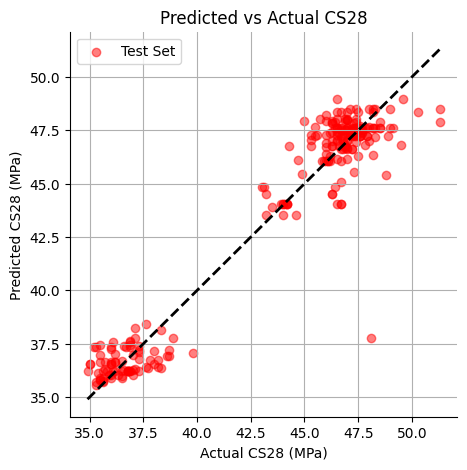

<IPython.core.display.Javascript object>

In [16]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



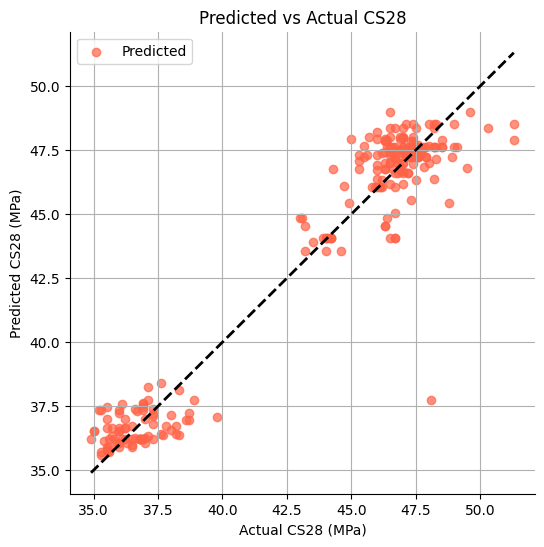

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


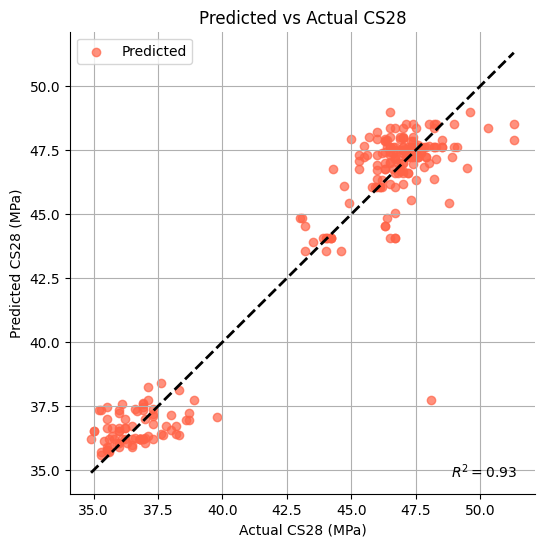

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.93
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig("inn_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


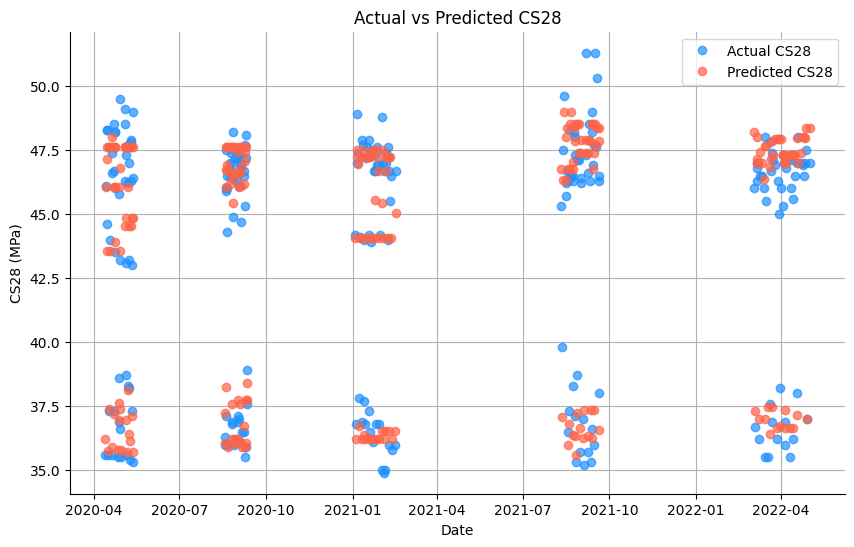

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [20]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [21]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Anhydrite,Calcite,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,#200,#325
Importances - 0,0.000043,0.048129,0.000000,0.000000,0.000000,0.000089,0.000000,0.023800,0.000329,0.000000,...,0.000000,0.000000,0.000000,0.001922,0.010206,0.00000,0.000000,0.000000,0.360616,0.549497
Importances - 1,0.000751,0.000000,0.000749,0.000000,0.000000,0.009407,0.000238,0.005125,0.005382,0.000000,...,0.000000,0.009756,0.000000,0.004867,0.006256,0.00000,0.000000,0.000000,0.189412,0.742901
Importances - 2,0.000355,0.003260,0.002345,0.001654,0.000000,0.000595,0.002025,0.000443,0.000123,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033324,0.00029,0.000785,0.000000,0.000000,0.944963
Importances - 3,0.007041,0.000000,0.007306,0.000000,0.000764,0.000000,0.008669,0.000000,0.000000,0.000733,...,0.000000,0.000000,0.000000,0.001355,0.026509,0.00000,0.000000,0.008866,0.003818,0.933607
Importances - 4,0.000000,0.000171,0.000238,0.003957,0.003658,0.001954,0.000000,0.003456,0.000000,0.002025,...,0.001049,0.000000,0.000605,0.000000,0.000000,0.00000,0.000110,0.000000,0.780597,0.194208


<IPython.core.display.Javascript object>

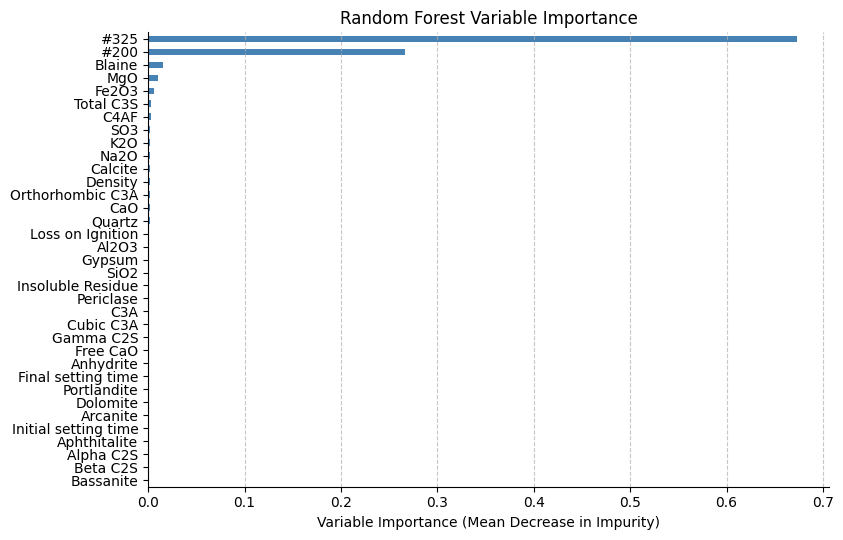

<IPython.core.display.Javascript object>

In [22]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

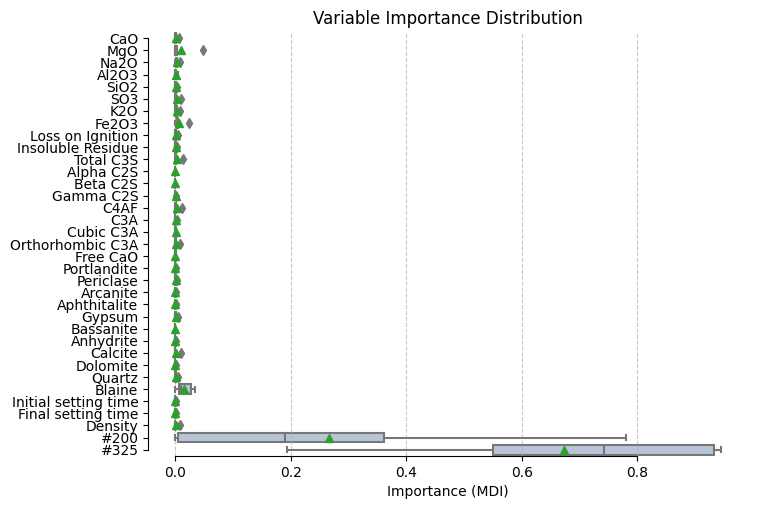

<IPython.core.display.Javascript object>

In [23]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


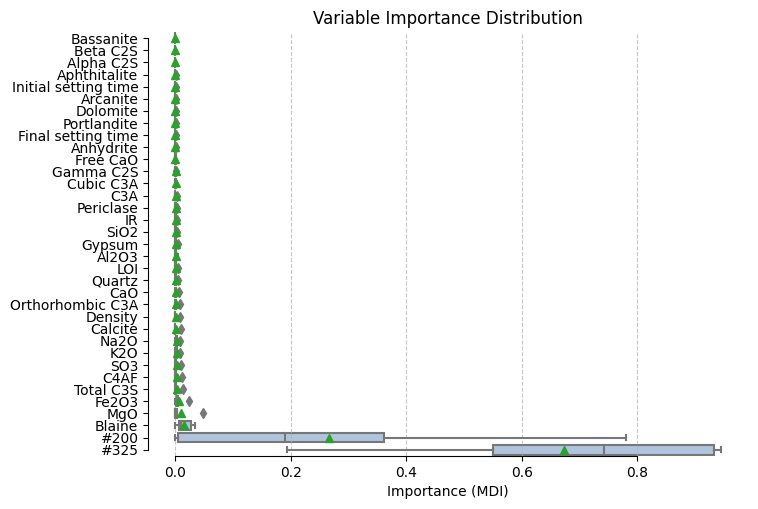

<IPython.core.display.Javascript object>

In [24]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("inn_cm_p_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


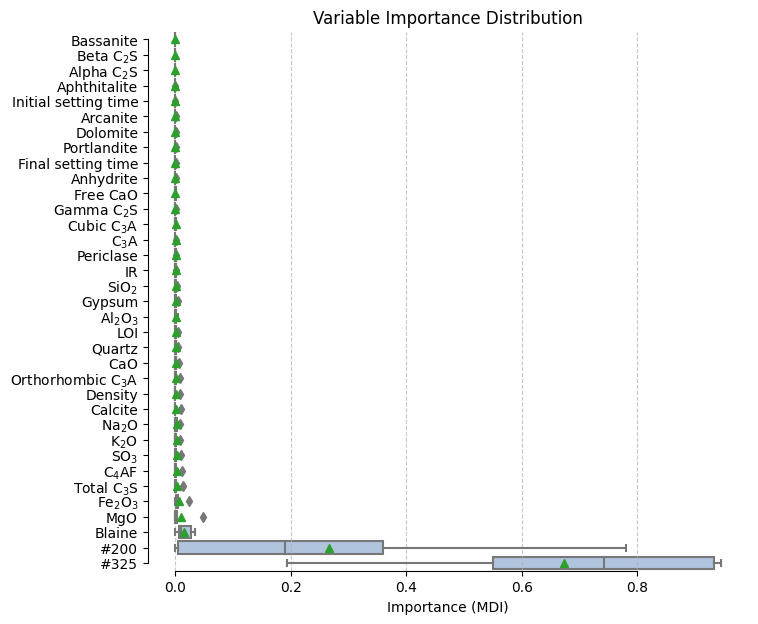

<IPython.core.display.Javascript object>

In [25]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [26]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Anhydrite,Calcite,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,#200,#325
Importances - 0,0.000043,0.048129,0.000000,0.000000,0.000000,0.000089,0.000000,0.023800,0.000329,0.000000,...,0.000000,0.000000,0.000000,0.001922,0.010206,0.00000,0.000000,0.000000,0.360616,0.549497
Importances - 1,0.000751,0.000000,0.000749,0.000000,0.000000,0.009407,0.000238,0.005125,0.005382,0.000000,...,0.000000,0.009756,0.000000,0.004867,0.006256,0.00000,0.000000,0.000000,0.189412,0.742901
Importances - 2,0.000355,0.003260,0.002345,0.001654,0.000000,0.000595,0.002025,0.000443,0.000123,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033324,0.00029,0.000785,0.000000,0.000000,0.944963
Importances - 3,0.007041,0.000000,0.007306,0.000000,0.000764,0.000000,0.008669,0.000000,0.000000,0.000733,...,0.000000,0.000000,0.000000,0.001355,0.026509,0.00000,0.000000,0.008866,0.003818,0.933607
Importances - 4,0.000000,0.000171,0.000238,0.003957,0.003658,0.001954,0.000000,0.003456,0.000000,0.002025,...,0.001049,0.000000,0.000605,0.000000,0.000000,0.00000,0.000110,0.000000,0.780597,0.194208


<IPython.core.display.Javascript object>

In [27]:
df_importances.describe().T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Bassanite,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Beta C2S,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Alpha C2S,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aphthitalite,5.0,0.000055,0.000124,0.000000,0.000000,0.000000,0.000000,0.000277
Initial setting time,5.0,0.000058,0.000130,0.000000,0.000000,0.000000,0.000000,0.000290
Arcanite,5.0,0.000059,0.000133,0.000000,0.000000,0.000000,0.000000,0.000297
Dolomite,5.0,0.000121,0.000271,0.000000,0.000000,0.000000,0.000000,0.000605
Portlandite,5.0,0.000153,0.000342,0.000000,0.000000,0.000000,0.000000,0.000764
Final setting time,5.0,0.000179,0.000342,0.000000,0.000000,0.000000,0.000110,0.000785
Anhydrite,5.0,0.000210,0.000469,0.000000,0.000000,0.000000,0.000000,0.001049


<IPython.core.display.Javascript object>

In [28]:
df_importances.mean(axis=0)

CaO                     0.001638
MgO                     0.010312
Na2O                    0.002127
Al2O3                   0.001122
SiO2                    0.000884
SO3                     0.002409
K2O                     0.002186
Fe2O3                   0.006565
Loss on Ignition        0.001167
Insoluble Residue       0.000552
Total C3S               0.002807
Alpha C2S               0.000000
Beta C2S                0.000000
Gamma C2S               0.000244
C4AF                    0.002536
C3A                     0.000398
Cubic C3A               0.000303
Orthorhombic C3A        0.001742
Free CaO                0.000219
Portlandite             0.000153
Periclase               0.000468
Arcanite                0.000059
Aphthitalite            0.000055
Gypsum                  0.000949
Bassanite               0.000000
Anhydrite               0.000210
Calcite                 0.001951
Dolomite                0.000121
Quartz                  0.001629
Blaine                  0.015259
Initial se

<IPython.core.display.Javascript object>

In [29]:
df_importances.std(axis=0, ddof=0)

CaO                     0.002715
MgO                     0.018949
Na2O                    0.002715
Al2O3                   0.001555
SiO2                    0.001418
SO3                     0.003568
K2O                     0.003329
Fe2O3                   0.008824
Loss on Ignition        0.002111
Insoluble Residue       0.000790
Total C3S               0.004885
Alpha C2S               0.000000
Beta C2S                0.000000
Gamma C2S               0.000488
C4AF                    0.004856
C3A                     0.000795
Cubic C3A               0.000331
Orthorhombic C3A        0.003014
Free CaO                0.000270
Portlandite             0.000306
Periclase               0.000768
Arcanite                0.000119
Aphthitalite            0.000111
Gypsum                  0.001691
Bassanite               0.000000
Anhydrite               0.000420
Calcite                 0.003902
Dolomite                0.000242
Quartz                  0.001786
Blaine                  0.012588
Initial se

<IPython.core.display.Javascript object>

In [30]:
df_copy.nunique()

Date                     651
CaO                     1215
MgO                     1216
Na2O                    1107
Al2O3                   1208
SiO2                    1213
SO3                     1213
K2O                     1178
Fe2O3                   1207
Loss on Ignition         579
Insoluble Residue        410
Total C3S                882
Alpha C2S                335
Beta C2S                 626
Gamma C2S                178
C4AF                     451
C3A                      310
Cubic C3A                278
Orthorhombic C3A         204
Free CaO                 167
Portlandite              292
Periclase                247
Arcanite                 267
Aphthitalite             104
Gypsum                   383
Bassanite                472
Anhydrite                 48
Calcite                  810
Dolomite                 293
Quartz                   256
Blaine                   349
Initial setting time      17
Final setting time        17
Density                   10
#200          

<IPython.core.display.Javascript object>

In [31]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [32]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [33]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

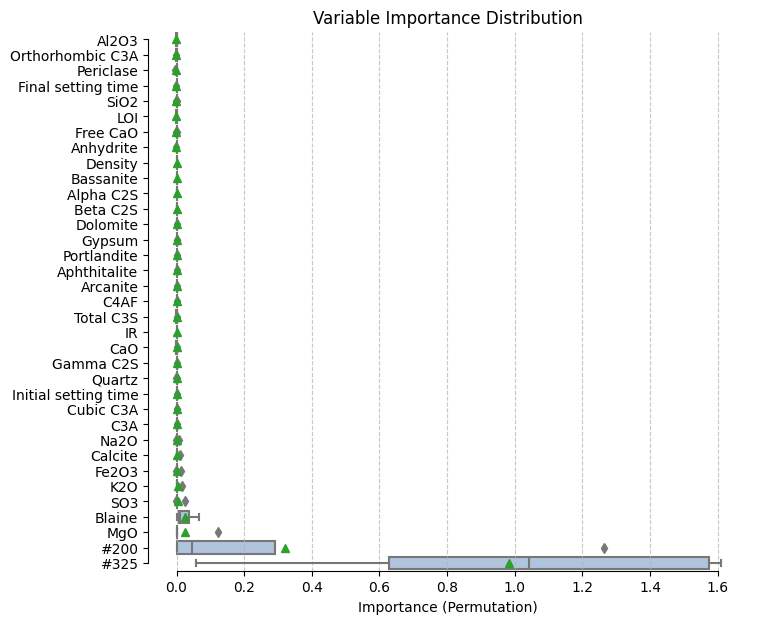

<IPython.core.display.Javascript object>

In [34]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

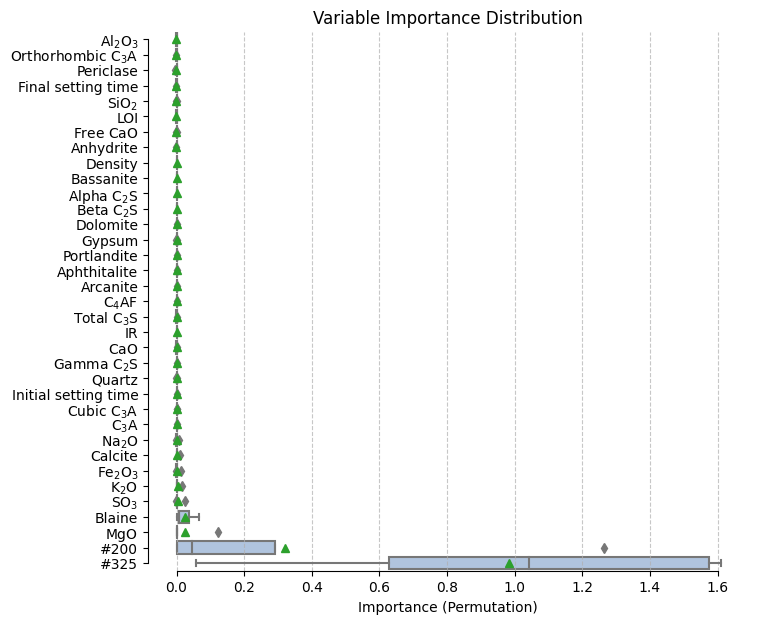

<IPython.core.display.Javascript object>

In [35]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [36]:
perm_importances_df.describe().T

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,count,mean,std,min,25%,50%,75%,max
Al2O3,5.0,-0.000856,0.001311,-0.002972,-0.001307,0.000000,0.000000,0.000000
Orthorhombic C3A,5.0,-0.000750,0.001176,-0.002686,-0.001063,0.000000,0.000000,0.000000
Periclase,5.0,-0.000696,0.001556,-0.003480,0.000000,0.000000,0.000000,0.000000
Final setting time,5.0,-0.000389,0.000805,-0.001826,-0.000120,0.000000,0.000000,0.000000
SiO2,5.0,-0.000305,0.001159,-0.002291,0.000000,0.000000,0.000000,0.000765
LOI,5.0,-0.000241,0.000332,-0.000656,-0.000549,0.000000,0.000000,0.000000
Free CaO,5.0,-0.000173,0.000530,-0.001104,0.000000,0.000000,0.000000,0.000238
Anhydrite,5.0,-0.000155,0.000347,-0.000775,0.000000,0.000000,0.000000,0.000000
Density,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bassanite,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [37]:
perm_importances_df

,Al2O3,Orthorhombic C3A,Periclase,Final setting time,SiO2,LOI,Free CaO,Anhydrite,Density,Bassanite,...,C3A,Na2O,Calcite,Fe2O3,K2O,SO3,Blaine,MgO,#200,#325
0,0.000000,0.000000,0.00000,0.000000,0.000000,-0.000549,-0.001104,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.014389,0.000000,0.000044,0.008837,0.121848,0.290673,0.627653
1,0.000000,0.000000,0.00000,0.000000,0.000000,-0.000656,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00907,0.000095,0.000132,0.024885,0.006219,0.000000,0.045813,1.041672
2,-0.001307,-0.001063,0.00000,-0.001826,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.007868,0.00000,-0.000416,0.000000,-0.001781,0.065429,0.000475,0.000000,1.573678
3,0.000000,0.000000,0.00000,0.000000,0.000765,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.000412,0.00000,0.000000,0.016142,0.000000,0.038304,0.000000,0.002502,1.609515
4,-0.002972,-0.002686,-0.00348,-0.000120,-0.002291,0.000000,0.000238,-0.000775,0.0,0.0,...,0.001905,-0.000064,0.00000,-0.000041,0.000000,0.000347,0.000000,0.000000,1.263115,0.056900


<IPython.core.display.Javascript object>

In [38]:
perm_importances_df.mean(axis=0)

Al2O3                  -0.000856
Orthorhombic C3A       -0.000750
Periclase              -0.000696
Final setting time     -0.000389
SiO2                   -0.000305
LOI                    -0.000241
Free CaO               -0.000173
Anhydrite              -0.000155
Density                 0.000000
Bassanite               0.000000
Alpha C2S               0.000000
Beta C2S                0.000000
Dolomite                0.000020
Gypsum                  0.000039
Portlandite             0.000056
Aphthitalite            0.000071
Arcanite                0.000083
C4AF                    0.000106
Total C3S               0.000127
IR                      0.000147
CaO                     0.000247
Gamma C2S               0.000276
Quartz                  0.000279
Initial setting time    0.000291
Cubic C3A               0.000372
C3A                     0.000381
Na2O                    0.001478
Calcite                 0.001814
Fe2O3                   0.002805
K2O                     0.003255
SO3       

<IPython.core.display.Javascript object>

In [39]:
perm_importances_df.std(axis=0, ddof=0)

Al2O3                   0.001173
Orthorhombic C3A        0.001052
Periclase               0.001392
Final setting time      0.000720
SiO2                    0.001036
LOI                     0.000297
Free CaO                0.000474
Anhydrite               0.000310
Density                 0.000000
Bassanite               0.000000
Alpha C2S               0.000000
Beta C2S                0.000000
Dolomite                0.000039
Gypsum                  0.000131
Portlandite             0.000112
Aphthitalite            0.000142
Arcanite                0.000165
C4AF                    0.000213
Total C3S               0.000670
IR                      0.000203
CaO                     0.000728
Gamma C2S               0.000553
Quartz                  0.000905
Initial setting time    0.000583
Cubic C3A               0.000750
C3A                     0.000762
Na2O                    0.003198
Calcite                 0.003628
Fe2O3                   0.005794
K2O                     0.006444
SO3       

<IPython.core.display.Javascript object>

In [40]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>